In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
# print(os.getcwd())

In [6]:
from tools.misc_tools import create_Lorenz_data, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder

In [7]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [8]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
tf.test.gpu_device_name()

2022-09-15 19:07:00.716068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:00.716470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:00.716823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:00.717261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:00.717693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

'/device:GPU:0'

719903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:00.720169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 3369 MB memory:  -> device: 1, name: Quadro K2200, pci bus id: 0000:03:00.0, compute capability: 5.0


In [12]:
tf.config.list_physical_devices()

2022-09-15 19:07:45.412622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:45.413036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:45.413392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:45.413732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:07:45.414065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Lorenz System

In [13]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # simutlation paramaters
    sigma_arr = np.array([10])
    rho_arr = np.array([20])
    beta_arr = np.array([4/3])

    x0 = 1
    y0 = 1
    z0 = 1

    t0 = 0.0
    T = 100.0
    delta_t = 0.01

    return_params_arr = False
    normalize_flag = True

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')

    # saving sim data
    sim_data = {
        'rho_arr':rho_arr,
        'sigma_arr':sigma_arr,
        'beta_arr':beta_arr,
        'x0':x0,
        'y0':y0,
        'z0':z0,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'normalize_flag':normalize_flag
    }
    with open(dir_name_ae+dir_sep+'sim_data_params.txt', 'w') as f:
        f.write(str(sim_data))

else:
    # simutlation paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_003'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    rho_arr = params_dict['rho_arr']
    sigma_arr = params_dict['sigma_arr']
    beta_arr = params_dict['beta_arr']

    x0 = params_dict['x0']
    y0 = params_dict['y0']
    z0 = params_dict['z0']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

In [14]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [15]:
n = len(boundary_idx_arr)
# # '''
# num_cols = 1
# num_rows = n

# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

# prev_idx = 0
# for i in range(n):
#     # ax = plt.axes(projection ='3d')
#     next_idx = boundary_idx_arr[i]
    
#     ax_orig = fig.add_subplot(num_rows, num_cols, i+1, projection ='3d')
#     ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
#     ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:]))
#     ax_orig.set_xlabel('x')
#     ax_orig.set_ylabel('y')
#     ax_orig.set_zlabel('z')
    
#     # ax_predict = fig.add_subplot(num_rows, num_cols, 2*i+2, projection ='3d')
#     # ax_predict.plot(reconstructed_data[prev_idx:next_idx, 0], reconstructed_data[prev_idx:next_idx, 1], reconstructed_data[prev_idx:next_idx, 2])
#     # ax_predict.title.set_text(r'NN Reconstructed Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
#     # )
#     # ax_predict.set_xlabel('x')
#     # ax_predict.set_ylabel('y')
#     # ax_predict.set_zlabel('z')

#     prev_idx = next_idx
# # '''

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 200  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# setting up data
idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1-test_split)*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
testing_data = all_data[idx[boundary:], :]

In [18]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    ae_net = Autoencoder(
        data_dim=6,
        enc_layers=[16,12,8,8,4,4,2],
        dec_layers=[2,4,4,8,8,12,16],
        latent_space_dim=2,
        lambda_reg=lambda_reg,
        reg_name='L2',
        enc_layer_act_func='elu',
        enc_final_layer_act_func='tanh',
        dec_layer_act_func='elu',
        dec_final_layer_act_func='linear',
        load_file=None)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + 'final_net_class_dict.txt'
    ae_net = Autoencoder(data_dim=6, load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = dir_name_ae+dir_sep+'checkpoints'+dir_sep+'checkpoint'
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
    ae_net.load_weights_from_file(wt_file)

2022-09-15 19:08:41.324899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:08:41.325285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:08:41.325624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:08:41.325952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 19:08:41.326266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [20]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
            validation_split=val_split/train_split,
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
124/124 [==============================] - 2s 8ms/step - loss: 42.1691 - val_loss: 0.2456
Epoch 2/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0494 - val_loss: 0.0340
Epoch 3/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0341 - val_loss: 0.0346
Epoch 4/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0341 - val_loss: 0.0334
Epoch 5/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0340 - tot_time: 0h 0m 5.8s

Epoch 5: val_loss improved from inf to 0.03364, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/ch

Epoch 33/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0338 - val_loss: 0.0331
Epoch 34/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0339 - val_loss: 0.0330
Epoch 35/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0336 - tot_time: 0h 0m 31.7s

Epoch 35: val_loss did not improve from 0.03230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 36/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0338 - val_loss: 0.0338
Epoch 37/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 38/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0329 - val_loss: 0.0318
Epoch 39/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0318
Epoch 40/2000
1

Epoch 67/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0145 - val_loss: 0.0151
Epoch 68/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 69/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 70/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0144 - tot_time: 0h 1m 2.4s

Epoch 70: val_loss improved from 0.01490 to 0.01384, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 71/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 72/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0141 - val_loss: 0.0147
Epoch 73/2000


124/124 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 102/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 103/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 104/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0122
Epoch 105/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0114 - tot_time: 0h 1m 31.9s

Epoch 105: val_loss did not improve from 0.01202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0129
Epoch 106/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 107/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 108/2000
124/124

Epoch 136/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 137/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 138/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 139/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 140/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0108 - tot_time: 0h 2m 1.4s

Epoch 140: val_loss did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0145
Epoch 141/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 142/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 14

Epoch 172/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 173/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 174/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 175/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0101 - tot_time: 0h 2m 30.7s

Epoch 175: val_loss improved from 0.01083 to 0.01020, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 176/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 177/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 

124/124 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 207/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 208/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 209/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0118
Epoch 210/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0103 - tot_time: 0h 3m 1.3s

Epoch 210: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 211/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 212/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 213/2000
124/124 

118/124 [===========================>..] - ETA: 0s - loss: 0.0022 - tot_time: 0h 3m 27.7s

Epoch 240: val_loss improved from 0.00235 to 0.00227, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 241/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 242/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 243/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 244/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 245/2000
124/124 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 3m 32.3s

Epoch 245: val_loss

124/124 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 274/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 275/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0017 - tot_time: 0h 3m 58.3s

Epoch 275: val_loss did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 276/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 277/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 278/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 279/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 280/2000
120/124

Epoch 308/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 309/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 310/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0016 - tot_time: 0h 4m 27.8s

Epoch 310: val_loss did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 311/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 312/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 313/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 314/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3

Epoch 343/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 344/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 345/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0015 - tot_time: 0h 4m 57.2s

Epoch 345: val_loss did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 346/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 347/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 348/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 349/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3

Epoch 379/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 380/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0015 - tot_time: 0h 5m 27.2s

Epoch 380: val_loss did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 381/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 382/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 383/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 384/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 385/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0015 - tot_time: 0h 5m 31.3s

Epoch

124/124 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 415/2000
124/124 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 5m 56.8s

Epoch 415: val_loss did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 416/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 417/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 418/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 419/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 420/2000
116/124 [===========================>..] - ETA: 0s - loss: 0.0015 - tot_time: 0h 6m 0.8s

Epoch 420: val_loss i

Epoch 450/2000
116/124 [===========================>..] - ETA: 0s - loss: 0.0015 - tot_time: 0h 6m 26.4s

Epoch 450: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 451/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 452/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 453/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 454/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 455/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0015 - tot_time: 0h 6m 30.8s

Epoch 455: val_loss improved from 0.00144 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/L

124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 485/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0014 - tot_time: 0h 6m 56.2s

Epoch 485: val_loss did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 486/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 487/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 488/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 489/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 490/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 7m 0.5s

Epoch 490: val_loss d

Epoch 520/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 7m 25.7s

Epoch 520: val_loss did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 521/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 522/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 523/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 524/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 525/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 7m 30.0s

Epoch 525: val_loss did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/

121/124 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 7m 55.0s

Epoch 555: val_loss did not improve from 0.00132
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 556/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 557/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 558/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 559/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 560/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 7m 59.1s

Epoch 560: val_loss did not improve from 0.00132
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/sa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 591/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 592/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 593/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 594/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 595/2000
114/124 [==========================>...] - ETA: 0s - loss: 0.0013 - tot_time: 0h 8m 28.6s

Epoch 595: val_loss did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0015
E

Epoch 626/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 627/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 628/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 629/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 630/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0013 - tot_time: 0h 8m 58.7s

Epoch 630: val_loss did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 631/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 632/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6

Epoch 662/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 663/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 664/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 665/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0013 - tot_time: 0h 9m 28.4s

Epoch 665: val_loss improved from 0.00127 to 0.00126, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 666/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 667/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 

124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 698/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 699/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 700/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0013 - tot_time: 0h 9m 58.5s

Epoch 700: val_loss did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 701/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 702/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 703/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 704/2000
124/124

124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 733/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 734/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 735/2000
124/124 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 10m 27.9s

Epoch 735: val_loss did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 736/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 737/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 738/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 739/2000
124/12

124/124 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 768/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 769/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 770/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0013 - tot_time: 0h 10m 58.0s

Epoch 770: val_loss did not improve from 0.00121
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 771/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 772/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 773/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 774/2000
124/12

Epoch 803/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 804/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 805/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0013 - tot_time: 0h 11m 27.3s

Epoch 805: val_loss did not improve from 0.00121
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 806/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 807/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 808/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 809/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 

124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 839/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 840/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0013 - tot_time: 0h 11m 57.3s

Epoch 840: val_loss did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 841/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 842/2000
124/124 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 843/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 844/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 845/2000
119/12

Epoch 874/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 875/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 12m 27.3s

Epoch 875: val_loss did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 876/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 877/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 878/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 879/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 880/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 12m 31.4s

Epo

Epoch 910/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 12m 57.0s

Epoch 910: val_loss did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 911/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 912/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 913/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 914/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 915/2000
115/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 13m 1.0s

Epoch 915: val_loss improved from 0.00119 to 0.00118, saving model to /home/rkaushik/Documents/Thesis/MLROM/

121/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 13m 26.2s

Epoch 945: val_loss did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 946/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 947/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 948/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 949/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 950/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 13m 30.5s

Epoch 950: val_loss did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/

123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 13m 56.4s

Epoch 980: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 981/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 982/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 983/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 984/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 985/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 14m 0.5s

Epoch 985: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/s

120/124 [============================>.] - ETA: 0s - loss: 0.0013 - tot_time: 0h 14m 26.0s

Epoch 1015: val_loss did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1016/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1017/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1018/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1019/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1020/2000
115/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 14m 30.1s

Epoch 1020: val_loss did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

122/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 14m 56.1s

Epoch 1050: val_loss improved from 0.00115 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1051/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1052/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1053/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1054/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 1055/2000
112/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 15m 0.4s

Epoch 1055: 

121/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 15m 25.9s

Epoch 1085: val_loss did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1086/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1087/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1088/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1089/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1090/2000
124/124 [==============================] - ETA: 0s - loss: 0.0012 - tot_time: 0h 15m 30.1s

Epoch 1090: val_loss did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1121/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1122/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1123/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1124/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1125/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0012 - tot_time: 0h 16m 0.2s

Epoch 1125: val_loss improved from 0.00114 to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/Los

Epoch 1156/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1157/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1158/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1159/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1160/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 16m 30.1s

Epoch 1160: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1161/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1162/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.001

Epoch 1192/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1193/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1194/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1195/2000
114/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 17m 0.2s

Epoch 1195: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1196/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1197/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1198/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 1228/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1229/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1230/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 17m 30.5s

Epoch 1230: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1231/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1232/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1233/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1234/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.001

Epoch 1263/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1264/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1265/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 18m 0.9s

Epoch 1265: val_loss did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1266/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1267/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1268/2000
124/124 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 1269/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012

124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1299/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1300/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 18m 31.5s

Epoch 1300: val_loss did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1301/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1302/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1303/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1304/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1305/200

Epoch 1334/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1335/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 19m 1.5s

Epoch 1335: val_loss did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1336/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1337/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1338/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1339/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1340/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 19m 5.9

Epoch 1369/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1370/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 19m 31.4s

Epoch 1370: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1371/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1372/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1373/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1374/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 1375/2000
113/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 19m 35

Epoch 1404/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1405/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 20m 1.7s

Epoch 1405: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 1406/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1407/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 1408/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1409/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1410/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 20m 6.0

Epoch 1440/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 20m 31.4s

Epoch 1440: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1441/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1442/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1443/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1444/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1445/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 20m 35.5s

Epoch 1445: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documen

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1476/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1477/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1478/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1479/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1480/2000
113/124 [==========================>...] - ETA: 0s - loss: 0.0012 - tot_time: 0h 21m 4.7s

Epoch 1480: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.

Epoch 1511/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 1512/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1513/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1514/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1515/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 21m 34.4s

Epoch 1515: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1516/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1517/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.001

Epoch 1547/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1548/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1549/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1550/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 22m 4.2s

Epoch 1550: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1551/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1552/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1553/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012

Epoch 1583/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1584/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1585/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 22m 34.5s

Epoch 1585: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1586/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1587/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1588/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1589/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.001

Epoch 1619/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1620/2000
116/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 23m 4.7s

Epoch 1620: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 1621/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1622/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1623/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1624/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 1625/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 23m 9.2

Epoch 1655/2000
111/124 [=========================>....] - ETA: 0s - loss: 0.0011 - tot_time: 0h 23m 35.0s

Epoch 1655: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1656/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1657/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1658/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1659/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1660/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 23m 39.3s

Epoch 1660: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documen

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1691/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1692/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1693/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1694/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1695/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 24m 9.6s

Epoch 1695: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.

Epoch 1726/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1727/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1728/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1729/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1730/2000
124/124 [==============================] - ETA: 0s - loss: 0.0011 - tot_time: 0h 24m 40.0s

Epoch 1730: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1731/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1732/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.001

Epoch 1762/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1763/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1764/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1765/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 25m 10.8s

Epoch 1765: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1766/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1767/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1768/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.001

Epoch 1797/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1798/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1799/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1800/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 25m 40.7s

Epoch 1800: val_loss did not improve from 0.00107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1801/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1802/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1803/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.001

Epoch 1833/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1834/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1835/2000
112/124 [==========================>...] - ETA: 0s - loss: 0.0011 - tot_time: 0h 26m 10.4s

Epoch 1835: val_loss did not improve from 0.00107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1836/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1837/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1838/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 1839/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.001

Epoch 1868/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1869/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1870/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 26m 40.6s

Epoch 1870: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1871/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1872/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1873/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1874/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.001

124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1904/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1905/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 27m 10.8s

Epoch 1905: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1906/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1907/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1908/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1909/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1910/200

Epoch 1939/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1940/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 27m 40.5s

Epoch 1940: val_loss did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1941/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1942/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1943/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1944/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1945/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 27m 44

Epoch 1974/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1975/2000
115/124 [==========================>...] - ETA: 0s - loss: 0.0011 - tot_time: 0h 28m 10.2s

Epoch 1975: val_loss did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1976/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1977/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1978/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1979/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1980/2000
116/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 28m 14

Epoch 8/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 28m 41.0s

Epoch 10: val_loss improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 13/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 14/2000


Epoch 44/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 45/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 29m 11.7s

Epoch 45: val_loss did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 46/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 47/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 48/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 49/2000
124/124 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 50/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 29m 16.2s

Epoch 50: v

Epoch 80/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 29m 41.8s

Epoch 80: val_loss did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 81/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 82/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 83/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 84/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 85/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 29m 46.5s

Epoch 85: val_loss improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/

Epoch 115/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 30m 12.3s

Epoch 115: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 116/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 117/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 118/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 119/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 120/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 30m 16.8s

Epoch 120: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesi

124/124 [==============================] - ETA: 0s - loss: 0.0011 - tot_time: 0h 30m 42.3s

Epoch 150: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 151/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 152/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 153/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 154/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 155/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 30m 46.4s

Epoch 155: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/

123/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 31m 11.8s

Epoch 185: val_loss improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 186/2000
124/124 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 187/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 188/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 189/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 190/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 31m 16.1s

Epoch 190: val_lo

116/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 31m 41.6s

Epoch 220: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 221/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 222/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 223/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 224/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 225/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 31m 45.7s

Epoch 225: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/

Epoch 255/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 32m 11.7s

Epoch 255: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 256/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 257/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 258/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 259/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 260/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0011 - tot_time: 0h 32m 16.0s

Epoch 260: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 291/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 292/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 293/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 294/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 295/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 32m 45.7s

Epoch 295: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010


Epoch 326/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 327/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 328/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 329/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 330/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 33m 15.0s

Epoch 330: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 331/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 332/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 

124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 362/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 363/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 364/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 365/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 33m 44.7s

Epoch 365: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 366/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 367/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 368/2000
124/12

124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 397/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 398/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 399/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 400/2000
124/124 [==============================] - ETA: 0s - loss: 0.0010 - tot_time: 0h 34m 14.5s

Epoch 400: val_loss did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 401/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 402/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 403/2000
124/12

Epoch 431/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 432/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 433/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 434/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 435/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 34m 45.6s

Epoch 435: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 436/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 437/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 

Epoch 467/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 468/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 469/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 470/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 35m 16.4s

Epoch 470: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 471/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 472/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 473/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 

124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 502/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 503/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 504/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 505/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 35m 47.3s

Epoch 505: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 506/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 507/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 508/2000
124/12

124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 537/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 538/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 539/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 540/2000
116/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 36m 18.0s

Epoch 540: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 541/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 542/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 543/2000
124/12

Epoch 572/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 573/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 574/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 575/2000
120/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 36m 48.5s

Epoch 575: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 576/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 577/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 578/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 

Epoch 607/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 608/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 609/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 610/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 37m 19.5s

Epoch 610: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 611/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 612/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 613/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 

Epoch 643/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 644/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 645/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 37m 50.1s

Epoch 645: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 646/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 647/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 648/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 649/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 

Epoch 679/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 680/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 38m 20.3s

Epoch 680: val_loss did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 681/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 682/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 683/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 684/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 685/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 38m 24.7s

Epo

Epoch 714/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 715/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 38m 51.5s

Epoch 715: val_loss did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 716/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 717/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 718/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 719/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 720/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 38m 56.0s

Epo

Epoch 749/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 750/2000
117/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 39m 22.5s

Epoch 750: val_loss did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 751/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 752/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 753/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 754/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 755/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 39m 27.2s

Epo

124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 785/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 39m 53.6s

Epoch 785: val_loss did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 786/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 787/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 788/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 789/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 790/2000
121/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 39m 58.3s

Epoch 790: val_los

Epoch 820/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 40m 25.4s

Epoch 820: val_loss improved from 0.00102 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 821/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 822/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 823/2000
124/124 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 824/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 825/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 40m 29.9s

Ep

Epoch 855/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 40m 56.4s

Epoch 855: val_loss did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 856/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 857/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 858/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 859/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 860/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 41m 0.8s

Epoch 860: val_loss improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/

119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 41m 27.4s

Epoch 890: val_loss improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 891/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 892/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 893/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 894/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 895/2000
123/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 41m 31.9s

Epoch 895: val_lo

124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 925/2000
118/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 41m 58.0s

Epoch 925: val_loss improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 926/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 927/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 928/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 929/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 930/2000
120/1

Epoch 959/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 960/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 42m 29.0s

Epoch 960: val_loss did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 961/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 962/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.9846e-04
Epoch 963/2000
124/124 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 964/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.9896e-04
Epoch 965/2000
122/124 [============================>.] - ETA: 0s - loss: 0.0010 - tot_time: 0h 42m 33

Epoch 994/2000
124/124 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 9.9938e-04
Epoch 995/2000
119/124 [===========================>..] - ETA: 0s - loss: 0.0010 - tot_time: 0h 42m 60.0s

Epoch 995: val_loss did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.9685e-04
Epoch 996/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.9381e-04
Epoch 997/2000
124/124 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 998/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.9079e-04
Epoch 999/2000
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1000/2000
118/124 [===========================>..] - ETA: 0s - loss: 9.9979e-04 - tot_ti

124/124 [==============================] - 1s 8ms/step - loss: 9.9682e-04 - val_loss: 9.8992e-04
Epoch 1028/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.9767e-04 - val_loss: 9.9292e-04
Epoch 1029/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.9612e-04 - val_loss: 9.8941e-04
Epoch 1030/2000
123/124 [============================>.] - ETA: 0s - loss: 9.9491e-04 - tot_time: 0h 43m 31.6s

Epoch 1030: val_loss improved from 0.00099 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 9.9499e-04 - val_loss: 9.8376e-04
Epoch 1031/2000
124/124 [==============================] - 1s 5ms/step - loss: 9.9476e-04 - val_loss: 9.8819e-04
Epoch 1032/2000
124/124 [==============================] - 1s 8ms/step - lo

Epoch 1061/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.8984e-04 - val_loss: 9.8004e-04
Epoch 1062/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.8570e-04 - val_loss: 0.0010
Epoch 1063/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.8732e-04 - val_loss: 0.0010
Epoch 1064/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.8620e-04 - val_loss: 9.7945e-04
Epoch 1065/2000
120/124 [============================>.] - ETA: 0s - loss: 9.8652e-04 - tot_time: 0h 44m 2.7s

Epoch 1065: val_loss did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 9.8807e-04 - val_loss: 9.9073e-04
Epoch 1066/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.8984e-04 - val_loss: 9.8760e-04
Epoch 1067/2000
124/124 [==============================] - 1

Epoch 1094/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.7718e-04 - val_loss: 9.7321e-04
Epoch 1095/2000
121/124 [============================>.] - ETA: 0s - loss: 9.8000e-04 - tot_time: 0h 44m 30.1s

Epoch 1095: val_loss improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 9.8024e-04 - val_loss: 9.6945e-04
Epoch 1096/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.7737e-04 - val_loss: 9.6667e-04
Epoch 1097/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.7560e-04 - val_loss: 9.8485e-04
Epoch 1098/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.7408e-04 - val_loss: 9.8254e-04
Epoch 1099/2000
124/124 [==============================] - 

Epoch 1126/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.6443e-04 - val_loss: 9.6186e-04
Epoch 1127/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.6187e-04 - val_loss: 9.5751e-04
Epoch 1128/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.6101e-04 - val_loss: 9.5652e-04
Epoch 1129/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.6073e-04 - val_loss: 9.5804e-04
Epoch 1130/2000
113/124 [==========================>...] - ETA: 0s - loss: 9.6436e-04 - tot_time: 0h 45m 1.2s

Epoch 1130: val_loss improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 9.6201e-04 - val_loss: 9.5777e-04
Epoch 1131/2000
124/124 [==============================] - 1

124/124 [==============================] - 1s 7ms/step - loss: 9.4436e-04 - val_loss: 9.4943e-04
Epoch 1159/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.4369e-04 - val_loss: 9.4176e-04
Epoch 1160/2000
119/124 [===========================>..] - ETA: 0s - loss: 9.3948e-04 - tot_time: 0h 45m 28.4s

Epoch 1160: val_loss improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 9.4094e-04 - val_loss: 9.3620e-04
Epoch 1161/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.4297e-04 - val_loss: 9.3470e-04
Epoch 1162/2000
124/124 [==============================] - 1s 7ms/step - loss: 9.4199e-04 - val_loss: 9.4067e-04
Epoch 1163/2000
124/124 [==============================] - 1s 8ms/step - lo

Epoch 1190/2000
115/124 [==========================>...] - ETA: 0s - loss: 9.2427e-04 - tot_time: 0h 45m 55.1s

Epoch 1190: val_loss improved from 0.00092 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 9.2343e-04 - val_loss: 9.1587e-04
Epoch 1191/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.1874e-04 - val_loss: 9.1079e-04
Epoch 1192/2000
124/124 [==============================] - 1s 8ms/step - loss: 9.1631e-04 - val_loss: 9.1133e-04
Epoch 1193/2000
124/124 [==============================] - 1s 6ms/step - loss: 9.1630e-04 - val_loss: 9.3802e-04
Epoch 1194/2000
124/124 [==============================] - 1s 9ms/step - loss: 9.1588e-04 - val_loss: 9.1608e-04
Epoch 1195/2000
117/124 [===========================>..] - 

Epoch 1221/2000
124/124 [==============================] - 1s 6ms/step - loss: 8.8973e-04 - val_loss: 8.9600e-04
Epoch 1222/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.9012e-04 - val_loss: 8.9615e-04
Epoch 1223/2000
124/124 [==============================] - 1s 7ms/step - loss: 8.8738e-04 - val_loss: 9.0914e-04
Epoch 1224/2000
124/124 [==============================] - 1s 6ms/step - loss: 8.8761e-04 - val_loss: 9.2630e-04
Epoch 1225/2000
120/124 [============================>.] - ETA: 0s - loss: 8.9104e-04 - tot_time: 0h 46m 27.1s

Epoch 1225: val_loss improved from 0.00089 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 8.9104e-04 - val_loss: 8.7892e-04
Epoch 1226/2000
124/124 [==============================] - 

124/124 [==============================] - 1s 8ms/step - loss: 8.6020e-04 - val_loss: 8.5154e-04
Epoch 1254/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.5616e-04 - val_loss: 8.5148e-04
Epoch 1255/2000
123/124 [============================>.] - ETA: 0s - loss: 8.5572e-04 - tot_time: 0h 46m 53.7s

Epoch 1255: val_loss improved from 0.00086 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 8.5571e-04 - val_loss: 8.4986e-04
Epoch 1256/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.5667e-04 - val_loss: 8.8714e-04
Epoch 1257/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.5494e-04 - val_loss: 8.5481e-04
Epoch 1258/2000
124/124 [==============================] - 1s 6ms/step - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 8.2971e-04 - val_loss: 8.2421e-04
Epoch 1286/2000
124/124 [==============================] - 1s 6ms/step - loss: 8.2771e-04 - val_loss: 8.2766e-04
Epoch 1287/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.2674e-04 - val_loss: 8.1919e-04
Epoch 1288/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.2565e-04 - val_loss: 8.3964e-04
Epoch 1289/2000
124/124 [==============================] - 1s 6ms/step - loss: 8.2678e-04 - val_loss: 8.2984e-04
Epoch 1290/2000
124/124 [==============================] - ETA: 0s - loss: 8.2333e-04 - tot_time: 0h 47m 25.6s

Epoch 1290: val_loss improved from 0.00082 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis

124/124 [==============================] - 1s 7ms/step - loss: 8.0564e-04 - val_loss: 8.0072e-04
Epoch 1318/2000
124/124 [==============================] - 1s 7ms/step - loss: 8.0486e-04 - val_loss: 8.1352e-04
Epoch 1319/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.0634e-04 - val_loss: 8.0340e-04
Epoch 1320/2000
118/124 [===========================>..] - ETA: 0s - loss: 8.0666e-04 - tot_time: 0h 47m 52.1s

Epoch 1320: val_loss improved from 0.00080 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 8.0687e-04 - val_loss: 7.9825e-04
Epoch 1321/2000
124/124 [==============================] - 1s 8ms/step - loss: 8.0338e-04 - val_loss: 8.0663e-04
Epoch 1322/2000
124/124 [==============================] - 1s 8ms/step - lo

Epoch 1350/2000
120/124 [============================>.] - ETA: 0s - loss: 7.9239e-04 - tot_time: 0h 48m 18.6s

Epoch 1350: val_loss improved from 0.00079 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.9130e-04 - val_loss: 7.8512e-04
Epoch 1351/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.9168e-04 - val_loss: 8.1012e-04
Epoch 1352/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.9261e-04 - val_loss: 7.9556e-04
Epoch 1353/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.8790e-04 - val_loss: 7.8787e-04
Epoch 1354/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.8796e-04 - val_loss: 7.8634e-04
Epoch 1355/2000
121/124 [============================>.] - 

Epoch 1382/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.7991e-04 - val_loss: 7.7847e-04
Epoch 1383/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.7813e-04 - val_loss: 7.7943e-04
Epoch 1384/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.7855e-04 - val_loss: 7.8297e-04
Epoch 1385/2000
121/124 [============================>.] - ETA: 0s - loss: 7.7930e-04 - tot_time: 0h 48m 49.9s

Epoch 1385: val_loss did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.7953e-04 - val_loss: 9.0904e-04
Epoch 1386/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.8574e-04 - val_loss: 7.8667e-04
Epoch 1387/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.7777e-04 - val_loss: 7.8611e-04
Epoch 1388/2000
124/124 [==========================

119/124 [===========================>..] - ETA: 0s - loss: 7.7323e-04 - tot_time: 0h 49m 16.6s

Epoch 1415: val_loss did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.7207e-04 - val_loss: 7.7484e-04
Epoch 1416/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.7235e-04 - val_loss: 7.7411e-04
Epoch 1417/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.7244e-04 - val_loss: 7.9067e-04
Epoch 1418/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.7410e-04 - val_loss: 7.6964e-04
Epoch 1419/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.7249e-04 - val_loss: 7.6931e-04
Epoch 1420/2000
121/124 [============================>.] - ETA: 0s - loss: 7.7357e-04 - tot_time: 0h 49m 21.2s

Epoch 1420: val_loss did not improve from 0.00077
 - saving loss his

124/124 [==============================] - 1s 8ms/step - loss: 7.6486e-04 - val_loss: 7.8148e-04
Epoch 1448/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.6568e-04 - val_loss: 7.6574e-04
Epoch 1449/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.6591e-04 - val_loss: 7.7623e-04
Epoch 1450/2000
120/124 [============================>.] - ETA: 0s - loss: 7.6632e-04 - tot_time: 0h 49m 48.4s

Epoch 1450: val_loss improved from 0.00077 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 7.6524e-04 - val_loss: 7.6554e-04
Epoch 1451/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.6448e-04 - val_loss: 7.7065e-04
Epoch 1452/2000
124/124 [==============================] - 1s 8ms/step - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.6077e-04 - val_loss: 7.6615e-04
Epoch 1481/2000
124/124 [==============================] - 1s 9ms/step - loss: 7.6084e-04 - val_loss: 7.6294e-04
Epoch 1482/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.6118e-04 - val_loss: 7.6930e-04
Epoch 1483/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.6039e-04 - val_loss: 7.6331e-04
Epoch 1484/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.6246e-04 - val_loss: 7.6249e-04
Epoch 1485/2000
114/124 [==========================>...] - ETA: 0s - loss: 7.6148e-04 - tot_time: 0h 50m 19.7s

Epoch 1485: val_loss did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================

124/124 [==============================] - 1s 8ms/step - loss: 7.5839e-04 - val_loss: 7.5783e-04
Epoch 1514/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.5695e-04 - val_loss: 7.5782e-04
Epoch 1515/2000
116/124 [===========================>..] - ETA: 0s - loss: 7.5790e-04 - tot_time: 0h 50m 46.8s

Epoch 1515: val_loss did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.5643e-04 - val_loss: 7.6064e-04
Epoch 1516/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.5643e-04 - val_loss: 7.6017e-04
Epoch 1517/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.5561e-04 - val_loss: 7.7033e-04
Epoch 1518/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.5584e-04 - val_loss: 7.6275e-04
Epoch 1519/2000
124/124 [==============================] - 1s 7ms/s

Epoch 1546/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.5343e-04 - val_loss: 7.6436e-04
Epoch 1547/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.5383e-04 - val_loss: 7.6078e-04
Epoch 1548/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.5251e-04 - val_loss: 7.5665e-04
Epoch 1549/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.5259e-04 - val_loss: 7.5406e-04
Epoch 1550/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.5350e-04 - tot_time: 0h 51m 17.2s

Epoch 1550: val_loss did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.5345e-04 - val_loss: 7.6631e-04
Epoch 1551/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.5273e-04 - val_loss: 7.6433e-04
Epoch 1552/2000
124/124 [==========================

124/124 [==============================] - 1s 7ms/step - loss: 7.4947e-04 - val_loss: 7.5660e-04
Epoch 1580/2000
124/124 [==============================] - ETA: 0s - loss: 7.5001e-04 - tot_time: 0h 51m 43.1s

Epoch 1580: val_loss improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 9ms/step - loss: 7.5001e-04 - val_loss: 7.5203e-04
Epoch 1581/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.4936e-04 - val_loss: 7.6974e-04
Epoch 1582/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.5103e-04 - val_loss: 7.5252e-04
Epoch 1583/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.5026e-04 - val_loss: 7.5340e-04
Epoch 1584/2000
124/124 [==============================] - 1s 7ms/step - lo

Epoch 1612/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4739e-04 - val_loss: 7.5273e-04
Epoch 1613/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4873e-04 - val_loss: 7.5609e-04
Epoch 1614/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.4899e-04 - val_loss: 7.4825e-04
Epoch 1615/2000
123/124 [============================>.] - ETA: 0s - loss: 7.4717e-04 - tot_time: 0h 52m 13.2s

Epoch 1615: val_loss did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.4714e-04 - val_loss: 7.7325e-04
Epoch 1616/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4803e-04 - val_loss: 7.5068e-04
Epoch 1617/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.4736e-04 - val_loss: 7.5285e-04
Epoch 1618/2000
124/124 [==========================

Epoch 1646/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.4537e-04 - val_loss: 7.5077e-04
Epoch 1647/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.4414e-04 - val_loss: 7.4606e-04
Epoch 1648/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4450e-04 - val_loss: 7.5634e-04
Epoch 1649/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.4585e-04 - val_loss: 7.5169e-04
Epoch 1650/2000
120/124 [============================>.] - ETA: 0s - loss: 7.4454e-04 - tot_time: 0h 52m 43.1s

Epoch 1650: val_loss improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.4366e-04 - val_loss: 7.4809e-04
Epoch 1651/2000
124/124 [==============================] - 

124/124 [==============================] - 1s 6ms/step - loss: 7.4319e-04 - val_loss: 7.4486e-04
Epoch 1680/2000
120/124 [============================>.] - ETA: 0s - loss: 7.4325e-04 - tot_time: 0h 53m 9.0s

Epoch 1680: val_loss did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.4242e-04 - val_loss: 7.5213e-04
Epoch 1681/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4318e-04 - val_loss: 7.6539e-04
Epoch 1682/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.4555e-04 - val_loss: 7.6988e-04
Epoch 1683/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4518e-04 - val_loss: 7.4959e-04
Epoch 1684/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4438e-04 - val_loss: 7.4646e-04
Epoch 1685/2000
123/124 [============================>.] - ETA: 0s -

Epoch 1713/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4092e-04 - val_loss: 7.4330e-04
Epoch 1714/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.4019e-04 - val_loss: 7.4992e-04
Epoch 1715/2000
118/124 [===========================>..] - ETA: 0s - loss: 7.4049e-04 - tot_time: 0h 53m 39.1s

Epoch 1715: val_loss improved from 0.00074 to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.4103e-04 - val_loss: 7.4340e-04
Epoch 1716/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4079e-04 - val_loss: 7.4468e-04
Epoch 1717/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.4004e-04 - val_loss: 7.4325e-04
Epoch 1718/2000
124/124 [==============================] - 

Epoch 1746/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3895e-04 - val_loss: 7.5399e-04
Epoch 1747/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.3967e-04 - val_loss: 7.5435e-04
Epoch 1748/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3990e-04 - val_loss: 7.4038e-04
Epoch 1749/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3892e-04 - val_loss: 7.4268e-04
Epoch 1750/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.3872e-04 - tot_time: 0h 54m 9.6s

Epoch 1750: val_loss did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.3875e-04 - val_loss: 7.4484e-04
Epoch 1751/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.4136e-04 - val_loss: 7.5033e-04
Epoch 1752/2000
124/124 [===========================

Epoch 1780/2000
122/124 [============================>.] - ETA: 0s - loss: 7.3783e-04 - tot_time: 0h 54m 35.7s

Epoch 1780: val_loss did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.3754e-04 - val_loss: 7.4065e-04
Epoch 1781/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3914e-04 - val_loss: 7.4318e-04
Epoch 1782/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.3984e-04 - val_loss: 7.4126e-04
Epoch 1783/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3856e-04 - val_loss: 7.4113e-04
Epoch 1784/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3838e-04 - val_loss: 7.4101e-04
Epoch 1785/2000
124/124 [==============================] - ETA: 0s - loss: 7.3646e-04 - tot_time: 0h 54m 40.0s

Epoch 1785: val_loss did not improve from 0.00074
 -

Epoch 1814/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.3508e-04 - val_loss: 7.5039e-04
Epoch 1815/2000
118/124 [===========================>..] - ETA: 0s - loss: 7.3665e-04 - tot_time: 0h 55m 6.1s

Epoch 1815: val_loss did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.3727e-04 - val_loss: 7.4250e-04
Epoch 1816/2000
124/124 [==============================] - 1s 9ms/step - loss: 7.3731e-04 - val_loss: 7.3763e-04
Epoch 1817/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3551e-04 - val_loss: 7.4322e-04
Epoch 1818/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3671e-04 - val_loss: 7.4249e-04
Epoch 1819/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3642e-04 - val_loss: 7.4640e-04
Epoch 1820/2000
119/124 [===========================

Epoch 1846/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3419e-04 - val_loss: 7.4250e-04
Epoch 1847/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3505e-04 - val_loss: 7.5791e-04
Epoch 1848/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.3645e-04 - val_loss: 7.3670e-04
Epoch 1849/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3459e-04 - val_loss: 8.2180e-04
Epoch 1850/2000
124/124 [==============================] - ETA: 0s - loss: 7.4044e-04 - tot_time: 0h 55m 37.7s

Epoch 1850: val_loss did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.4044e-04 - val_loss: 7.7817e-04
Epoch 1851/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.3679e-04 - val_loss: 7.3831e-04
Epoch 1852/2000
124/124 [==========================

Epoch 1880/2000
115/124 [==========================>...] - ETA: 0s - loss: 7.3452e-04 - tot_time: 0h 56m 3.9s

Epoch 1880: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 5ms/step - loss: 7.3285e-04 - val_loss: 7.3488e-04
Epoch 1881/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3298e-04 - val_loss: 7.5096e-04
Epoch 1882/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3511e-04 - val_loss: 7.3995e-04
Epoch 1883/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.3380e-04 - val_loss: 7.3518e-04
Epoch 1884/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3319e-04 - val_loss: 7.3522e-04
Epoch 1885/2000
120/124 [============================>.] - ETA: 0s - loss: 7.3393e-04 - tot_time: 0h 56m 8.4s

Epoch 1885: val_loss did not improve from 0.00073
 - s

Epoch 1913/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.3170e-04 - val_loss: 7.3610e-04
Epoch 1914/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3170e-04 - val_loss: 7.3996e-04
Epoch 1915/2000
121/124 [============================>.] - ETA: 0s - loss: 7.3368e-04 - tot_time: 0h 56m 33.9s

Epoch 1915: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.3385e-04 - val_loss: 7.6454e-04
Epoch 1916/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.3855e-04 - val_loss: 7.4037e-04
Epoch 1917/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3138e-04 - val_loss: 7.3887e-04
Epoch 1918/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3111e-04 - val_loss: 7.3778e-04
Epoch 1919/2000
124/124 [==========================

Epoch 1947/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3153e-04 - val_loss: 7.3328e-04
Epoch 1948/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2899e-04 - val_loss: 7.3236e-04
Epoch 1949/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2998e-04 - val_loss: 7.4500e-04
Epoch 1950/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.3205e-04 - tot_time: 0h 57m 4.1s

Epoch 1950: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.3224e-04 - val_loss: 7.3976e-04
Epoch 1951/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.3109e-04 - val_loss: 7.3788e-04
Epoch 1952/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2979e-04 - val_loss: 7.4091e-04
Epoch 1953/2000
124/124 [===========================

124/124 [==============================] - ETA: 0s - loss: 7.3082e-04 - tot_time: 0h 57m 29.7s

Epoch 1980: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.3082e-04 - val_loss: 7.4116e-04
Epoch 1981/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2890e-04 - val_loss: 7.3430e-04
Epoch 1982/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.3014e-04 - val_loss: 7.4108e-04
Epoch 1983/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.3069e-04 - val_loss: 7.3630e-04
Epoch 1984/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2914e-04 - val_loss: 7.3281e-04
Epoch 1985/2000
118/124 [===========================>..] - ETA: 0s - loss: 7.2867e-04 - tot_time: 0h 57m 34.0s

Epoch 1985: val_loss did not improve from 0.00073
 - saving loss his

124/124 [==============================] - 1s 8ms/step - loss: 7.2545e-04 - val_loss: 7.2990e-04
Epoch 13/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2541e-04 - val_loss: 7.2934e-04
Epoch 14/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2536e-04 - val_loss: 7.3046e-04
Epoch 15/2000
123/124 [============================>.] - ETA: 0s - loss: 7.2569e-04 - tot_time: 0h 58m 0.3s

Epoch 15: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2567e-04 - val_loss: 7.3011e-04
Epoch 16/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2543e-04 - val_loss: 7.3037e-04
Epoch 17/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2561e-04 - val_loss: 7.2975e-04
Epoch 18/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2

Epoch 46/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2520e-04 - val_loss: 7.2985e-04
Epoch 47/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2532e-04 - val_loss: 7.3000e-04
Epoch 48/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2535e-04 - val_loss: 7.2966e-04
Epoch 49/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2573e-04 - val_loss: 7.2926e-04
Epoch 50/2000
122/124 [============================>.] - ETA: 0s - loss: 7.2619e-04 - tot_time: 0h 58m 30.2s

Epoch 50: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2573e-04 - val_loss: 7.3013e-04
Epoch 51/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2519e-04 - val_loss: 7.2986e-04
Epoch 52/2000
124/124 [==============================] - 1s 5ms/s

Epoch 80/2000
122/124 [============================>.] - ETA: 0s - loss: 7.2560e-04 - tot_time: 0h 58m 56.7s

Epoch 80: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2532e-04 - val_loss: 7.2950e-04
Epoch 81/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2523e-04 - val_loss: 7.2959e-04
Epoch 82/2000
124/124 [==============================] - 1s 9ms/step - loss: 7.2509e-04 - val_loss: 7.2965e-04
Epoch 83/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2517e-04 - val_loss: 7.2951e-04
Epoch 84/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2506e-04 - val_loss: 7.2962e-04
Epoch 85/2000
118/124 [===========================>..] - ETA: 0s - loss: 7.2536e-04 - tot_time: 0h 59m 0.9s

Epoch 85: val_loss did not improve from 0.00073
 - saving loss hist

Epoch 113/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2489e-04 - val_loss: 7.2915e-04
Epoch 114/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2504e-04 - val_loss: 7.3049e-04
Epoch 115/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.2590e-04 - tot_time: 0h 59m 27.0s

Epoch 115: val_loss improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2502e-04 - val_loss: 7.2870e-04
Epoch 116/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2507e-04 - val_loss: 7.2869e-04
Epoch 117/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2468e-04 - val_loss: 7.2978e-04
Epoch 118/2000
124/124 [==============================] - 1s 8ms/

Epoch 146/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2479e-04 - val_loss: 7.2897e-04
Epoch 147/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2491e-04 - val_loss: 7.2966e-04
Epoch 148/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2471e-04 - val_loss: 7.2898e-04
Epoch 149/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2480e-04 - val_loss: 7.2934e-04
Epoch 150/2000
121/124 [============================>.] - ETA: 0s - loss: 7.2430e-04 - tot_time: 0h 59m 58.0s

Epoch 150: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.2451e-04 - val_loss: 7.2951e-04
Epoch 151/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2481e-04 - val_loss: 7.2953e-04
Epoch 152/2000
124/124 [==============================] - 

124/124 [==============================] - ETA: 0s - loss: 7.2450e-04 - tot_time: 1h 0m 24.7s

Epoch 180: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2450e-04 - val_loss: 7.2908e-04
Epoch 181/2000
124/124 [==============================] - 1s 9ms/step - loss: 7.2518e-04 - val_loss: 7.2828e-04
Epoch 182/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2454e-04 - val_loss: 7.2892e-04
Epoch 183/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2456e-04 - val_loss: 7.2886e-04
Epoch 184/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2446e-04 - val_loss: 7.2909e-04
Epoch 185/2000
120/124 [============================>.] - ETA: 0s - loss: 7.2282e-04 - tot_time: 1h 0m 29.1s

Epoch 185: val_loss did not improve from 0.00073
 - saving loss histories at

124/124 [==============================] - 1s 6ms/step - loss: 7.2442e-04 - val_loss: 7.2841e-04
Epoch 214/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2411e-04 - val_loss: 7.2869e-04
Epoch 215/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.2486e-04 - tot_time: 1h 0m 56.2s

Epoch 215: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2444e-04 - val_loss: 7.2857e-04
Epoch 216/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2457e-04 - val_loss: 7.2816e-04
Epoch 217/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2419e-04 - val_loss: 7.2782e-04
Epoch 218/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2433e-04 - val_loss: 7.2930e-04
Epoch 219/2000
124/124 [==============================] - 1s 5ms/step - lo

Epoch 247/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2411e-04 - val_loss: 7.3016e-04
Epoch 248/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2442e-04 - val_loss: 7.2897e-04
Epoch 249/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2435e-04 - val_loss: 7.2874e-04
Epoch 250/2000
121/124 [============================>.] - ETA: 0s - loss: 7.2520e-04 - tot_time: 1h 1m 27.1s

Epoch 250: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.2431e-04 - val_loss: 7.2824e-04
Epoch 251/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2441e-04 - val_loss: 7.2875e-04
Epoch 252/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2399e-04 - val_loss: 7.2781e-04
Epoch 253/2000
124/124 [==============================] - 1

Epoch 281/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2402e-04 - val_loss: 7.2882e-04
Epoch 282/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2399e-04 - val_loss: 7.2801e-04
Epoch 283/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2411e-04 - val_loss: 7.2799e-04
Epoch 284/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2398e-04 - val_loss: 7.2862e-04
Epoch 285/2000
122/124 [============================>.] - ETA: 0s - loss: 7.2449e-04 - tot_time: 1h 1m 57.7s

Epoch 285: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 6ms/step - loss: 7.2390e-04 - val_loss: 7.2886e-04
Epoch 286/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2404e-04 - val_loss: 7.2847e-04
Epoch 287/2000
124/124 [==============================] - 1

118/124 [===========================>..] - ETA: 0s - loss: 7.2481e-04 - tot_time: 1h 2m 24.2s

Epoch 315: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.2378e-04 - val_loss: 7.2881e-04
Epoch 316/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2375e-04 - val_loss: 7.2767e-04
Epoch 317/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2373e-04 - val_loss: 7.2828e-04
Epoch 318/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2381e-04 - val_loss: 7.2838e-04
Epoch 319/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2390e-04 - val_loss: 7.2752e-04
Epoch 320/2000
124/124 [==============================] - ETA: 0s - loss: 7.2379e-04 - tot_time: 1h 2m 28.5s

Epoch 320: val_loss did not improve from 0.00073
 - saving loss histories at

124/124 [==============================] - 1s 7ms/step - loss: 7.2355e-04 - val_loss: 7.2836e-04
Epoch 349/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2359e-04 - val_loss: 7.2807e-04
Epoch 350/2000
121/124 [============================>.] - ETA: 0s - loss: 7.2339e-04 - tot_time: 1h 2m 55.0s

Epoch 350: val_loss improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2372e-04 - val_loss: 7.2742e-04
Epoch 351/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2383e-04 - val_loss: 7.2819e-04
Epoch 352/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2360e-04 - val_loss: 7.2779e-04
Epoch 353/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2

Epoch 381/2000
124/124 [==============================] - 1s 6ms/step - loss: 7.2317e-04 - val_loss: 7.2764e-04
Epoch 382/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2358e-04 - val_loss: 7.2774e-04
Epoch 383/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2364e-04 - val_loss: 7.2812e-04
Epoch 384/2000
124/124 [==============================] - 1s 5ms/step - loss: 7.2351e-04 - val_loss: 7.2782e-04
Epoch 385/2000
119/124 [===========================>..] - ETA: 0s - loss: 7.2308e-04 - tot_time: 1h 3m 25.2s

Epoch 385: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 8ms/step - loss: 7.2349e-04 - val_loss: 7.2754e-04
Epoch 386/2000
124/124 [==============================] - 1s 8ms/step - loss: 7.2325e-04 - val_loss: 7.2764e-04
Epoch 387/2000
124/124 [==============================] - 1

124/124 [==============================] - ETA: 0s - loss: 7.2318e-04 - tot_time: 1h 3m 50.8s

Epoch 415: val_loss did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Lorenz/saved_ae/ae_003/checkpoints/LossHistoriesCheckpoint
124/124 [==============================] - 1s 7ms/step - loss: 7.2318e-04 - val_loss: 7.2754e-04
Epoch 416/2000
124/124 [==============================] - 1s 7ms/step - loss: 7.2347e-04 - val_loss: 7.2803e-04
Epoch 417/2000
122/124 [============================>.] - ETA: 0s - loss: 7.2229e-04Restoring model weights from the end of the best epoch: 217.
 - tot_time: 1h 3m 52.4s
124/124 [==============================] - 1s 5ms/step - loss: 7.2336e-04 - val_loss: 7.2732e-04
Epoch 417: early stopping


In [22]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ae_net.evaluate(
        testing_data, testing_data,
    )

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    ae_net.save_everything(
        save_path+dir_sep+'final_net')

32/32 [==============================] - 0s 3ms/step - loss: 7.0646e-04


In [ ]:
lr_change

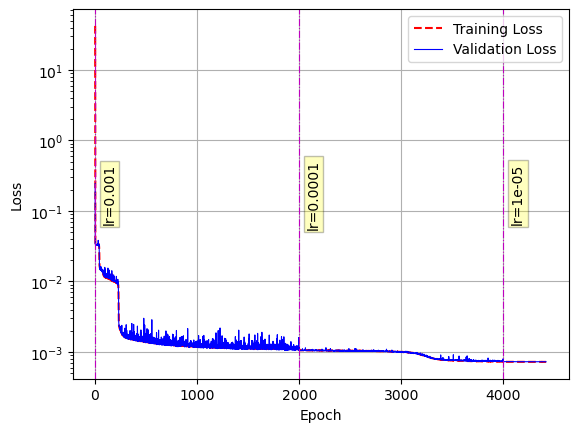

In [23]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [24]:
reconstructed_data = ae_net.predict(all_data)

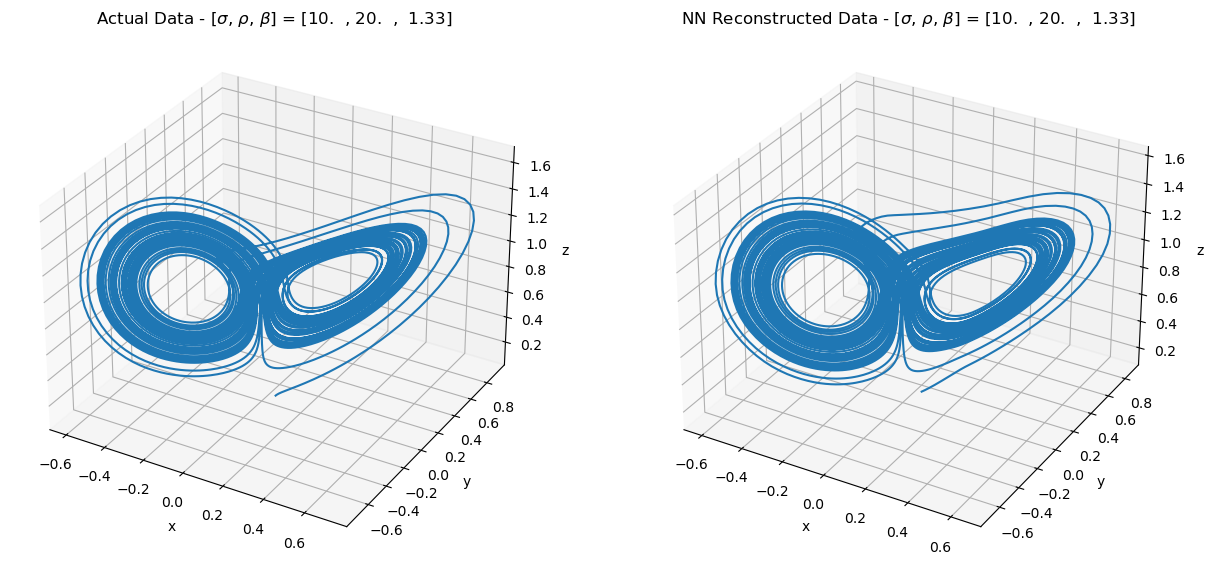

In [25]:
fig = plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=False)

In [26]:
plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=True)

In [27]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

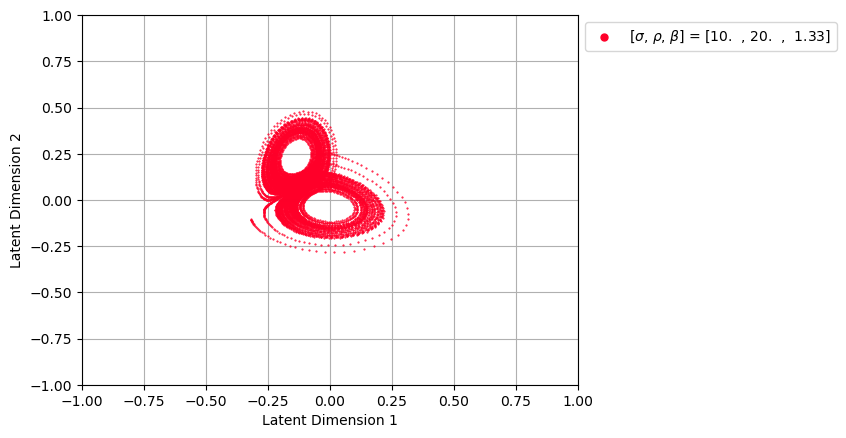

In [28]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10
    )

plt.savefig(dir_name_ae + '{ds}plots{ds}latent_space.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')

In [ ]:
# ae_net.summary()

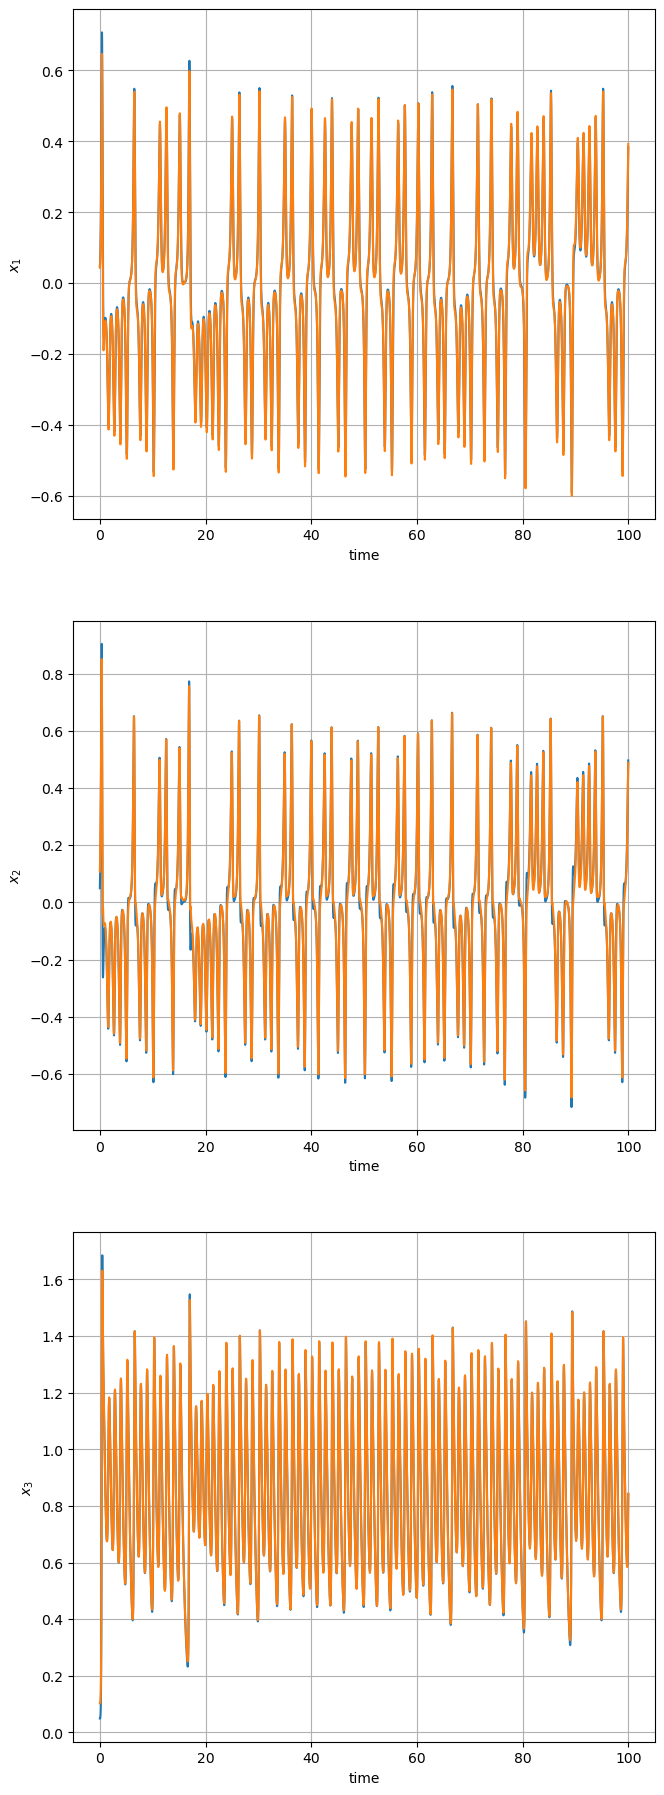

In [29]:
n = len(boundary_idx_arr)
num_cols = 1
num_rows = 3*n

# plt.ion()

fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

Tt = N * delta_t
time_arr = np.arange(0, N+1) * Tt / N

y_labels = [r'$x_1$', r'$x_2$', r'$x_3$']

prev_idx = 0
for i in range(n):
    # ax = plt.axes(projection ='3d')
    next_idx = boundary_idx_arr[i]

    for j in range(3):
        ax = fig.add_subplot(num_rows, num_cols, 3*i+j+1)
        ax.plot(time_arr, all_data[prev_idx:next_idx, j], label='original')
        ax.plot(time_arr, reconstructed_data[prev_idx:next_idx, j], label='reconstructed')
        ax.set_ylabel(y_labels[j])
        ax.set_xlabel('time')
        ax.grid(True)


    prev_idx = next_idx

# LSTM